In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,LSTM

In [2]:
df=pd.read_csv(r'/kaggle/input/netflix-stock-price-prediction/NFLX.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900


In [3]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [4]:
df.shape

(1009, 7)

In [5]:
df=df["Close"]

In [7]:
scaler=MinMaxScaler((0,1))
data=scaler.fit_transform(np.array(df).reshape([df.shape[0],1]))

In [8]:
time_step=100
def createData(data):
    x=[]
    y=[]
    for i in range(len(data)-time_step-1):
        x.append(data[i:(i+time_step)])
        y.append(data[i+time_step])
    return x,y

In [9]:
x,y=createData(data)

In [10]:
x=np.array(x)
x=x.reshape(x.shape[0],x.shape[1],1)
y=np.array(y)

In [11]:
df.shape

(1009,)

In [12]:
xtrain,xtest,ytrain,ytest=x[:int(df.shape[0]*0.8)],x[int(df.shape[0]*0.8):],y[:int(df.shape[0]*0.8)],y[int(df.shape[0]*0.8):]

In [14]:
model=Sequential([
    LSTM(128,return_sequences=True,input_shape=xtrain[0].shape),
    LSTM(64,return_sequences=True),
    LSTM(32),
    Dense(16,activation="relu"),
    Dense(1)
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss="mean_squared_error",metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [15]:
model.fit(xtrain,ytrain,epochs=100)

Epoch 1/100
26/26 [==============================] - 11s 18ms/step - loss: 0.0471 - root_mean_squared_error: 0.2170
Epoch 2/100
26/26 [==============================] - 0s 16ms/step - loss: 0.0038 - root_mean_squared_error: 0.0614
Epoch 3/100
26/26 [==============================] - 0s 16ms/step - loss: 0.0030 - root_mean_squared_error: 0.0545
Epoch 4/100
26/26 [==============================] - 0s 16ms/step - loss: 0.0028 - root_mean_squared_error: 0.0529
Epoch 5/100
26/26 [==============================] - 0s 18ms/step - loss: 0.0028 - root_mean_squared_error: 0.0527
Epoch 6/100
26/26 [==============================] - 0s 18ms/step - loss: 0.0028 - root_mean_squared_error: 0.0530
Epoch 7/100
26/26 [==============================] - 0s 16ms/step - loss: 0.0027 - root_mean_squared_error: 0.0520
Epoch 8/100
26/26 [==============================] - 0s 17ms/step - loss: 0.0024 - root_mean_squared_error: 0.0495
Epoch 9/100
26/26 [==============================] - 0s 16ms/step - loss: 0.002

In [16]:
model.evaluate(xtest,ytest)

4/4 [==============================] - 1s 10ms/step - loss: 0.0018 - root_mean_squared_error: 0.0421


[0.0017730641411617398, 0.04210776835680008]

In [17]:
trainPred=scaler.inverse_transform(model.predict(xtrain)).squeeze()
testPred=scaler.inverse_transform(model.predict(xtest)).squeeze()

4/4 [==============================] - 0s 7ms/step


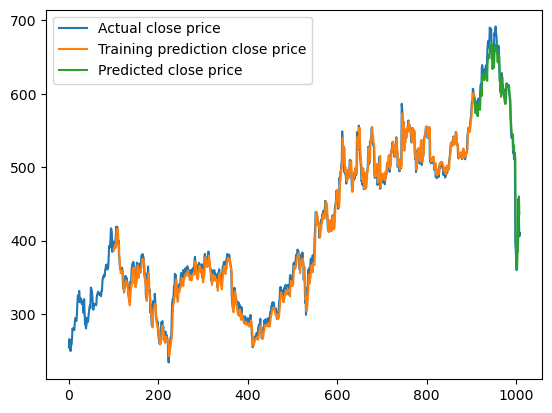

In [18]:
look_back=time_step
trainPredPlot=np.empty_like(df)
trainPredPlot[:]=np.nan
trainPredPlot[look_back:len(trainPred)+look_back]=trainPred
testPredPlot=np.empty_like(df)
testPredPlot[:]=np.nan
testPredPlot[len(trainPred)+look_back:len(trainPred)+look_back+len(testPred)]=testPred

plt.plot(df,label="Actual close price")
plt.plot(trainPredPlot,label="Training prediction close price")
plt.plot(testPredPlot,label="Predicted close price")
plt.legend()
plt.show()

In [19]:
input_data=np.array(df[-time_step:])
input_data=input_data.reshape([input_data.shape[0],1])

In [20]:
def predict(data,days=30):
    data=scaler.transform(data)
    predictions=[]
    i=1
    while(i<=days):
        nxtday=model.predict([data],verbose=0)
        predictions.append(scaler.inverse_transform(nxtday)[0])
        data[:-1]=data[1:]
        data[-1]=nxtday[0]
        i+=1
    return np.array(predictions).squeeze()       

In [21]:
# predictions
days=30
predictions=predict(input_data,days)

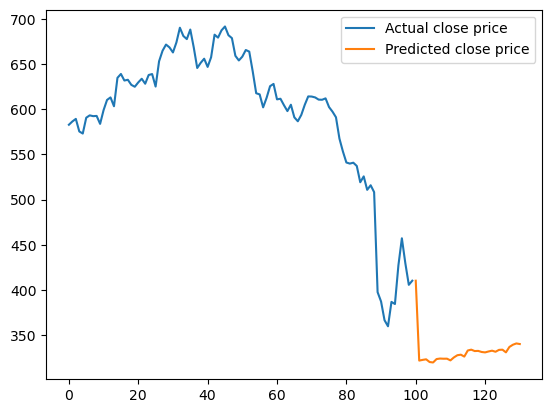

In [22]:
trainPredPlot=np.zeros(shape=[len(input_data)+1+days])
trainPredPlot[:]=np.nan
trainPredPlot[len(input_data)]=input_data[-1]
trainPredPlot[len(input_data)+1:]=predictions
df_=input_data
plt.plot(df_,label="Actual close price")
plt.plot(trainPredPlot,label="Predicted close price")
plt.legend()
plt.show()

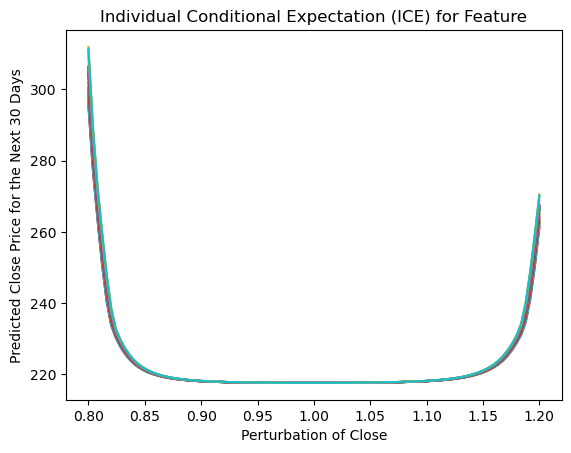

In [27]:
# Define a range of perturbations for the last 30 days of stock prices
perturbation_range = np.linspace(0.8, 1.2, num=100)  # Perturb the feature within this range

# Create a copy of the original data for perturbation
input_data_perturbed = input_data.copy()

# Generate ICE predictions by perturbing the last 30 days of stock prices
ice_predictions = []

for perturbation in perturbation_range:
    # Perturb the last 30 days of stock prices
    perturbed_data = input_data_perturbed[-time_step:] * perturbation
    input_data_perturbed[-time_step:] = perturbed_data
    
    # Predict the next 30 days using the perturbed data
    predictions = predict(input_data_perturbed, days=30)
    ice_predictions.append(predictions)

# Plot ICE
plt.plot(perturbation_range, ice_predictions)
plt.xlabel(f'Perturbation of {feature_name}')
plt.ylabel('Predicted Close Price for the Next 30 Days')
plt.title('Individual Conditional Expectation (ICE) for Feature')
plt.show()


In [40]:
 ice_predictions

[array([296.76965, 297.40857, 297.91168, 295.46725, 295.06836, 298.14163,
        298.60345, 298.44986, 298.49417, 296.94196, 299.60284, 301.55475,
        302.0206 , 300.34518, 305.6425 , 306.36575, 305.14447, 305.28067,
        304.33725, 303.98557, 304.79343, 305.47244, 304.54678, 306.17505,
        306.34888, 304.01904, 308.74792, 310.7286 , 311.90558, 311.36804],
       dtype=float32),
 array([278.00958, 278.49762, 278.86307, 277.01727, 276.71402, 279.02097,
        279.33896, 279.23282, 279.2633 , 278.14108, 280.0498 , 281.44897,
        281.8009 , 280.57938, 284.55753, 285.1125 , 284.1763 , 284.2805 ,
        283.5598 , 283.29187, 283.908  , 284.42728, 283.71967, 284.96603,
        285.09952, 283.31735, 286.95145, 288.49374, 289.4162 , 288.99435],
       dtype=float32),
 array([264.2138 , 264.6021 , 264.86758, 263.42484, 263.18387, 264.98538,
        265.2226 , 265.1434 , 265.16617, 264.31842, 265.7531 , 266.79843,
        267.0616 , 266.14856, 269.12708, 269.5439 , 268.841  , 2

In [41]:
predictions

array([262.15085, 262.51447, 262.80136, 261.38608, 261.1022 , 262.93268,
       263.19708, 263.10883, 263.1342 , 262.2488 , 263.7885 , 264.90564,
       265.1521 , 264.22937, 267.08655, 267.47696, 266.81854, 266.89178,
       266.38553, 266.19745, 266.63007, 266.99496, 266.4978 , 267.3739 ,
       267.4678 , 266.21533, 268.77322, 269.86386, 270.51776, 270.21857],
      dtype=float32)